# Sampling

Content credits on the [Acknowledgments Page](https://ds100.org/sp23/acks/).

Updated by Joseph Gonzalez, Dominic Liu, Fernando Pérez.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style='darkgrid', font_scale = 1.5,
              rc={'figure.figsize':(7,5)})

rng = np.random.default_rng()

## Barbie v. Oppenheimer

To study how various sampling strategies work we will use a (fictional)  **census** -- a complete survey of all Berkeley residents (our population). For the purposes of this fictional demo, assume:
* `wears_birkenstocks` indicates if a resident wears birks.
* There are only two movies they can watch on July 21st: Barbie and Oppenheimer.
* Every resident watches a movie (either Barbie or Oppenheimer) on July 21st.


In [2]:
census = pd.read_csv("movie_census.csv")
census['Barbie'] = census['movie'] == 'Barbie'
census

,age,wears_birkenstocks,movie,Barbie
0,35,False,Barbie,True
1,42,True,Oppenheimer,False
2,55,False,Barbie,True
3,77,True,Oppenheimer,False
4,31,False,Barbie,True
...,...,...,...,...
1299995,62,True,Barbie,True
1299996,78,True,Oppenheimer,False
1299997,68,False,Oppenheimer,False
1299998,82,True,Oppenheimer,False


What fraction of Berkeley residents chose Barbie?

In [3]:
actual_barbie = census["Barbie"].mean()
actual_barbie

0.5302792307692308

This is the **actual outcome** of the competition. Based on this result, Barbie would win.

## Convenience sample: _Undergrads in Prof. Gonzalez OH_

In [24]:
undergrads = census[(18 <= census['age']) & (census['age'] <= 22)].sample(10, replace=False)
undergrads["Barbie"].mean()

0.7

Based on this result, we would have predicted that Barbie would win! What happened?

1. Is the sample too small / noisy?

In [26]:
len(undergrads)

10

In [27]:
print("Percent of Berkeley:", len(undergrads)/len(census) * 100)

Percent of Berkeley: 0.0007692307692307692


## Convenience sample: _Elderly at a Campus Event_

In [38]:
elderly = census[census['age'] >= 65].sample(100)
elderly["Barbie"].mean()

0.33

Based on this result, we would have predicted that Oppenheimer would win! What happened?

1. Is the sample too small / noisy?

In [39]:
len(elderly)

100

In [40]:
print("Percent of Berkeley:", len(elderly)/len(census) * 100)

Percent of Berkeley: 0.007692307692307693


### Check for bias

Let us aggregate all choices by age and visualize the fraction of Barbie views, split by `wears_birkenstocks`.

In [44]:
votes_by_barbie = census.groupby(["age","wears_birkenstocks"]).agg("mean", numeric_only=True).reset_index()
votes_by_barbie

,age,wears_birkenstocks,Barbie
0,18,False,0.819594
1,18,True,0.667001
2,19,False,0.812214
3,19,True,0.661252
4,20,False,0.805281
...,...,...,...
125,80,True,0.259731
126,81,False,0.394946
127,81,True,0.256759
128,82,False,0.398970


In [42]:
import plotly.express as px
px.scatter(votes_by_barbie, x = "age", y = "Barbie", 
           color = "wears_birkenstocks",
           title= "Preferences by Demographics")

* We see that retirees (in Berkeley) tend to watch Oppenheimer.
* We also see that residents who don't routinely wear Birkenstocks tend to prefer Barbie (nothing wrong with Birkenstocks).

## Simple Random Sample

What if we instead took a simple random sample (SRS) to collect our sample?

Suppose we took an SRS:

In [57]:
## By default, replace = False
n = 10000
random_sample = census.sample(n, replace = False)

random_sample["Barbie"].mean()

0.5308

This is very close to the actual vote!

In [55]:
actual_barbie

0.5302792307692308

It turns out that we can get similar results with a **much smaller sample size**, say, 800:

In [81]:
n = 800
random_sample = census.sample(n, replace = False)

# Compute the sample average and the resulting relative error
sample_barbie = random_sample["Barbie"].mean()
err = abs(sample_barbie-actual_barbie)/actual_barbie

# We can print output with Markdown formatting too...
from IPython.display import Markdown
Markdown(f"**Actual** = {actual_barbie:.4f}, **Sample** = {sample_barbie:.4f}, "
         f"**Err** = {100*err:.2f}%.")

**Actual** = 0.5303, **Sample** = 0.5275, **Err** = 0.52%.

We'll learn how to choose this number when we (re)learn the Central Limit Theorem later in the semester.

### Quantifying chance error

In our SRS of size 800, what would be our chance error?

Let's simulate 1000 versions of taking the 800-sized SRS from before:

In [82]:
nrep = 1000   # number of simulations
n = 800       # size of our sample
poll_result = []
for i in range(0, nrep):
    random_sample = census.sample(n, replace = False)
    poll_result.append(random_sample["Barbie"].mean())

Visualizing the distribution of outcomes:

In [89]:
fig = px.histogram(poll_result, histnorm='probability density', nbins=50)
fig.add_vline(x=actual_barbie, line_width=3, line_dash="dash", line_color="orange")
fig.update_layout(showlegend=False)

# Add Kernel Density Estimate curve
from scipy import stats
from plotly import graph_objects as go
x = np.linspace(min(poll_result), max(poll_result), 100)
fig.add_trace(go.Scatter(
    x=x, 
    y=stats.gaussian_kde(poll_result)(x), # Library for KDE (auto selects bandwidth)
    mode='lines', line=dict(color='red', width=3)) # Formatting
    )


Using seaborn instead:

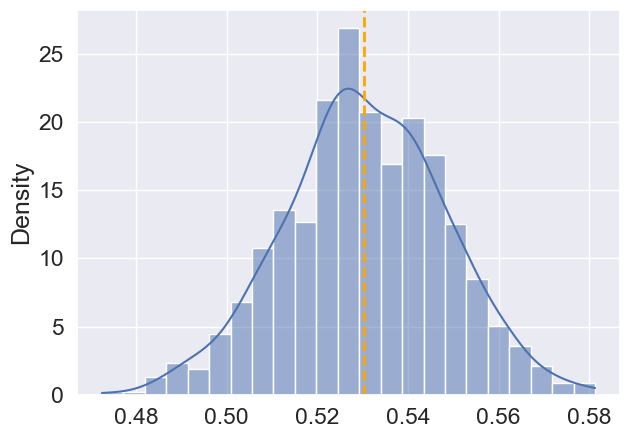

In [90]:
sns.histplot(poll_result, stat='density', kde=True);
plt.axvline(actual_barbie, color='orange', linestyle='dashed', linewidth=2)

What fraction of these simulated samples would have predicted Barbie?

In [91]:
poll_result = pd.Series(poll_result)
np.sum(poll_result > 0.5)/1000

0.951

##### Return to Slides

---

## Simulating from a Multinomial Distribution

Sometimes instead of having individual reports in the population, we have **aggregate** statistics. For example, we could have only learned that 53\% of election voters voted Democrat. Even so, we can still simulate probability samples if we assume the population is large.

Specifically, we can use **multinomial** probabilities to simulate random samples **with replacement**.

### Marbles

Suppose we have a very large bag of marbles with the following statistics:
* 60\% blue
* 30\% green
* 10\% red

We then draw 100 marbles from this bag at random with replacement.

In [92]:
np.random.multinomial(100, [0.60, 0.30, 0.10])

array([61, 28, 11])

We can repeat this simulation multiple times, say 20:

In [93]:
np.random.multinomial(100, [0.60, 0.30, 0.10], size=20)

array([[62, 34,  4],
       [68, 22, 10],
       [62, 29,  9],
       [52, 36, 12],
       [62, 27, 11],
       [56, 32, 12],
       [52, 31, 17],
       [56, 32, 12],
       [63, 27, 10],
       [55, 34, 11],
       [59, 30, 11],
       [61, 26, 13],
       [59, 24, 17],
       [66, 25,  9],
       [55, 26, 19],
       [62, 29,  9],
       [67, 23, 10],
       [68, 26,  6],
       [60, 33,  7],
       [55, 34, 11]])